<a href="https://colab.research.google.com/github/PadawanXXVI/spotify-data-storytelling/blob/main/spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎓 Spotify Data Storytelling — Semana 2  
## Coleta, Limpeza e Transformação de Dados

**Curso:** Tecnologia em Ciência de Dados — Faculdade de Tecnologia e Inovação Senac DF  
**Professor:** Alexsander Holanda Barreto  
**Autor:** Anderson de Matos Guimarães  

---

### 🎯 Objetivo da Semana 2
Esta etapa foca na **coleta via API do Spotify**, seguida por **limpeza, transformação e análise exploratória inicial**.  
O resultado final será um **dataset tratado (`spotify_semana2_tratado.csv`)** e um **relatório parcial** descrevendo metodologia e insights.

---

### 🧩 Etapas desta semana
1. Instalação e importação de bibliotecas.  
2. Autenticação segura na API.  
3. Coleta de faixas por gêneros brasileiros.  
4. Diagnóstico e inspeção inicial.  
5. Limpeza, padronização e criação de colunas derivadas.  
6. Exportação dos datasets bruto e tratado.  
7. Geração do relatório parcial.


In [20]:
# 🛠️ Instalação da biblioteca Spotipy (interface oficial da API do Spotify)
!pip install spotipy --quiet

print("✅ Spotipy instalada com sucesso!")


✅ Spotipy instalada com sucesso!


In [21]:
# ⚙️ Importação de bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


## 🔐 Autenticação Segura na API do Spotify  

Para garantir segurança e reprodutibilidade, as credenciais ficam armazenadas em variáveis de ambiente:  
- `SPOTIPY_CLIENT_ID`  
- `SPOTIPY_CLIENT_SECRET`  

Essas chaves são obtidas no [Spotify Developer Dashboard](https://developer.spotify.com/dashboard).


In [22]:
# 🔐 Autenticação segura usando secrets do Google Colab
from google.colab import userdata
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# 🔎 Recupera as chaves armazenadas em "Secrets"
client_id = userdata.get('SPOTIPY_CLIENT_ID')
client_secret = userdata.get('SPOTIPY_CLIENT_SECRET')

# ✅ Teste de autenticação
try:
    auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(auth_manager=auth_manager)
    sp.search(q="genre:pop", type="track", limit=1)
    print("🎧 Autenticação realizada com sucesso via Colab Secrets!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")


🎧 Autenticação realizada com sucesso via Colab Secrets!


In [23]:
# 🌎 Descoberta automática de categorias Spotify (Brasil)
print("🔎 Coletando categorias disponíveis no Spotify Brasil...")

# Busca até 50 categorias disponíveis
categorias_data = sp.categories(country="BR", limit=50)
categorias = {c["name"]: c["id"] for c in categorias_data["categories"]["items"]}

print(f"✅ Total de categorias encontradas: {len(categorias)}\n")
print("📋 Categorias disponíveis no Brasil:")
for nome in categorias.keys():
    print("-", nome)

# 🧩 Filtra categorias claramente musicais
categorias_musicais = [
    c for c in categorias.keys()
    if any(x in c.lower() for x in [
        "pop", "rock", "hip", "r&b", "dance", "latin", "metal", "jazz",
        "soul", "folk", "acoustic", "instrumental", "electronic",
        "country", "alternative", "blues", "gospel", "indie", "k-pop",
        "mpb", "sertanejo", "forró", "funk", "samba", "pagode"
    ])
]

print(f"\n🎶 Categorias musicais identificadas automaticamente ({len(categorias_musicais)}):")
print(categorias_musicais)

# 🔁 Substitui a lista manual de gêneros pela automática
generos_validos = categorias_musicais


🔎 Coletando categorias disponíveis no Spotify Brasil...
✅ Total de categorias encontradas: 50

📋 Categorias disponíveis no Brasil:
- Made For You
- New Releases
- Hip-Hop
- Country
- Pop
- Latin
- Charts
- Rock
- R&B
- Dance/Electronic
- Indie
- Fall
- Workout
- Mood
- Party
- Student
- Love
- Disney
- Netflix
- Chill
- Sleep
- Discover
- Jazz
- Metal
- Christian & Gospel
- Música Mexicana
- Happy Holidays
- Classical
- Decades
- Kids & Family
- In the car
- At Home
- EQUAL
- Spotify CLASSICS
- GLOW
- Frequency
- TV & Movies
- Trending
- Folk & Acoustic
- K-pop
- Punk
- Blues
- Soul
- Alternative
- Anime
- Instrumental
- RADAR
- Fresh Finds
- Songwriters
- Spotify Singles

🎶 Categorias musicais identificadas automaticamente (17):
['Hip-Hop', 'Country', 'Pop', 'Latin', 'Rock', 'R&B', 'Dance/Electronic', 'Indie', 'Jazz', 'Metal', 'Christian & Gospel', 'Folk & Acoustic', 'K-pop', 'Blues', 'Soul', 'Alternative', 'Instrumental']


In [24]:
# 🎧 Coleta automática de faixas musicais via API do Spotify (Brasil)

# 1️⃣ Lista de categorias musicais definidas dinamicamente
generos_validos = categorias_musicais
print(f"🎯 Total de gêneros a serem coletados: {len(generos_validos)}\n")

# 2️⃣ Estruturas de armazenamento
all_tracks = []
resumo = []

# 3️⃣ Loop de coleta
for genero in generos_validos:
    print(f"🎶 Buscando faixas da categoria: {genero}")
    try:
        results = sp.search(q=f"genre:{genero}", type="track", limit=50, market="BR")
        tracks = results["tracks"]["items"]

        # Caso nenhuma faixa seja encontrada
        if len(tracks) == 0:
            print(f"⚠️ Nenhum resultado encontrado para: {genero}")
            continue

        # Paginação — coleta até 500 resultados por categoria
        offset = 50
        while results["tracks"]["next"] and offset < 500:
            results = sp.next(results["tracks"])
            tracks.extend(results["tracks"]["items"])
            offset += 50

        # Estruturação dos dados
        for item in tracks:
            all_tracks.append({
                "genero": genero,
                "faixa": item["name"],
                "artista": item["artists"][0]["name"],
                "album": item["album"]["name"],
                "data_lancamento": item["album"]["release_date"],
                "popularidade": item["popularity"],
                "duracao_ms": item["duration_ms"]
            })

        resumo.append({"genero": genero, "qtd_faixas": len(tracks)})
        print(f"✅ {len(tracks)} faixas coletadas para {genero}")

    except Exception as e:
        print(f"❌ Erro ao coletar gênero {genero}: {e}")

# 4️⃣ Consolidação em DataFrame
df_raw = pd.DataFrame(all_tracks)
df_resumo = pd.DataFrame(resumo).sort_values("qtd_faixas", ascending=False)

print("\n📊 Resumo da coleta por gênero:")
display(df_resumo)

# 5️⃣ Exportação do dataset bruto
os.makedirs("/content/data", exist_ok=True)
df_raw.to_csv("/content/data/spotify_raw.csv", index=False)
print(f"💾 Dataset bruto exportado com sucesso! {len(df_raw)} faixas salvas em /content/data/spotify_raw.csv")


🎯 Total de gêneros a serem coletados: 17

🎶 Buscando faixas da categoria: Hip-Hop
✅ 100 faixas coletadas para Hip-Hop
🎶 Buscando faixas da categoria: Country
✅ 100 faixas coletadas para Country
🎶 Buscando faixas da categoria: Pop
✅ 100 faixas coletadas para Pop
🎶 Buscando faixas da categoria: Latin
✅ 100 faixas coletadas para Latin
🎶 Buscando faixas da categoria: Rock
✅ 100 faixas coletadas para Rock
🎶 Buscando faixas da categoria: R&B
✅ 100 faixas coletadas para R&B
🎶 Buscando faixas da categoria: Dance/Electronic
✅ 100 faixas coletadas para Dance/Electronic
🎶 Buscando faixas da categoria: Indie
✅ 100 faixas coletadas para Indie
🎶 Buscando faixas da categoria: Jazz
✅ 100 faixas coletadas para Jazz
🎶 Buscando faixas da categoria: Metal
✅ 100 faixas coletadas para Metal
🎶 Buscando faixas da categoria: Christian & Gospel
✅ 100 faixas coletadas para Christian & Gospel
🎶 Buscando faixas da categoria: Folk & Acoustic
✅ 100 faixas coletadas para Folk & Acoustic
🎶 Buscando faixas da categoria

,genero,qtd_faixas
0,Hip-Hop,100
1,Country,100
2,Pop,100
3,Latin,100
4,Rock,100
5,R&B,100
6,Dance/Electronic,100
7,Indie,100
8,Jazz,100
9,Metal,100


💾 Dataset bruto exportado com sucesso! 1700 faixas salvas em /content/data/spotify_raw.csv


## 🧹 Fase 2 — Limpeza e Transformação dos Dados (Semana 2)

Nesta etapa, realizamos o tratamento do dataset coletado pela API do Spotify.
As principais tarefas incluem:
- Verificar a integridade dos dados (ausentes, duplicados e tipos inconsistentes);
- Corrigir formatações de datas e durações;
- Normalizar variáveis numéricas;
- Exportar a base tratada para as análises exploratórias da próxima semana.

Esta fase é crucial para garantir **qualidade, consistência e confiabilidade** na análise de dados musicais.


In [25]:
# 📂 Importa o dataset bruto salvo na fase anterior
import pandas as pd

df_raw = pd.read_csv("/content/data/spotify_raw.csv")

print(f"✅ Dataset carregado com sucesso: {df_raw.shape[0]} linhas × {df_raw.shape[1]} colunas")
display(df_raw.head())


✅ Dataset carregado com sucesso: 1700 linhas × 7 colunas


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms
0,Hip-Hop,Shdy Nate Intro,Shady Nate,The Shady Bunch Vol. 2,2010-01-30,0,37933
1,Hip-Hop,KEILING FANS,Mo Money,MASTER MIND,2022-07-01,0,177345
2,Hip-Hop,Blap That Ass Up,Paris,Acid Reflex (Radio Safe Version),2008-10-28,0,281426
3,Hip-Hop,Com' On,Bo,Without Borders,2010-10-10,0,249533
4,Hip-Hop,Съзнание,Hoodini,На аванта I,2016-05-05,0,189333


In [26]:
# 🔍 Estrutura geral e estatísticas básicas
print("📋 Estrutura do dataset bruto:")
print()
print(f"Dimensões: {df_raw.shape[0]} linhas × {df_raw.shape[1]} colunas\n")
print(df_raw.info())
print("\n📈 Estatísticas descritivas iniciais:")
display(df_raw.describe(include='all'))


📋 Estrutura do dataset bruto:

Dimensões: 1700 linhas × 7 colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   genero           1700 non-null   object
 1   faixa            1700 non-null   object
 2   artista          1700 non-null   object
 3   album            1700 non-null   object
 4   data_lancamento  1700 non-null   object
 5   popularidade     1700 non-null   int64 
 6   duracao_ms       1700 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 93.1+ KB
None

📈 Estatísticas descritivas iniciais:


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms
count,1700,1700,1700,1700,1700,1700.000000,1700.000000
unique,17,1480,839,1284,1030,NaN,NaN
top,Hip-Hop,Hit the Road Jack,Linkin Park,The Life of a Showgirl + Acoustic Collection,2025-10-31,NaN,NaN
freq,100,4,35,14,22,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,54.124706,220635.817647
std,NaN,NaN,NaN,NaN,NaN,32.098010,81499.195608
min,NaN,NaN,NaN,NaN,NaN,0.000000,15270.000000
25%,NaN,NaN,NaN,NaN,NaN,35.750000,169900.250000
50%,NaN,NaN,NaN,NaN,NaN,68.000000,209468.500000
75%,NaN,NaN,NaN,NaN,NaN,77.000000,252176.500000


In [27]:
# 🧼 Limpeza e padronização
df = df_raw.copy()

# 1️⃣ Remover duplicatas
df.drop_duplicates(subset=["faixa", "artista", "album"], inplace=True)

# 2️⃣ Corrigir formato de data
df["data_lancamento"] = pd.to_datetime(df["data_lancamento"], errors="coerce")

# 3️⃣ Converter duração para minutos
df["duracao_min"] = (df["duracao_ms"] / 60000).round(2)

# 4️⃣ Normalizar a popularidade entre 0 e 1
df["popularidade_norm"] = df["popularidade"] / 100

# 5️⃣ Remover linhas com dados ausentes críticos
df.dropna(subset=["genero", "faixa", "artista", "album"], inplace=True)

print("✅ Limpeza concluída. Estrutura atualizada:")
print(df.info())


✅ Limpeza concluída. Estrutura atualizada:
<class 'pandas.core.frame.DataFrame'>
Index: 1539 entries, 0 to 1699
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genero             1539 non-null   object        
 1   faixa              1539 non-null   object        
 2   artista            1539 non-null   object        
 3   album              1539 non-null   object        
 4   data_lancamento    1458 non-null   datetime64[ns]
 5   popularidade       1539 non-null   int64         
 6   duracao_ms         1539 non-null   int64         
 7   duracao_min        1539 non-null   float64       
 8   popularidade_norm  1539 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 120.2+ KB
None


In [28]:
# 🧾 Diagnóstico final
print("🩶 Valores nulos restantes por coluna:")
print(df.isna().sum())

print("\n📊 Estatísticas descritivas após tratamento:")
display(df.describe(include='all'))


🩶 Valores nulos restantes por coluna:
genero                0
faixa                 0
artista               0
album                 0
data_lancamento      81
popularidade          0
duracao_ms            0
duracao_min           0
popularidade_norm     0
dtype: int64

📊 Estatísticas descritivas após tratamento:


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm
count,1539,1539,1539,1539,1458,1539.000000,1539.000000,1539.000000,1539.000000
unique,17,1480,839,1284,NaN,NaN,NaN,NaN,NaN
top,Hip-Hop,The Fate of Ophelia,Taylor Swift,DeBÍ TiRAR MáS FOToS,NaN,NaN,NaN,NaN,NaN
freq,100,4,28,14,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2014-02-17 10:58:45.925925888,52.206628,222498.365172,3.708317,0.522066
min,NaN,NaN,NaN,NaN,1952-04-01 00:00:00,0.000000,15270.000000,0.250000,0.000000
25%,NaN,NaN,NaN,NaN,2009-09-20 18:00:00,0.000000,172409.500000,2.875000,0.000000
50%,NaN,NaN,NaN,NaN,2019-04-20 12:00:00,66.000000,210625.000000,3.510000,0.660000
75%,NaN,NaN,NaN,NaN,2024-02-14 18:00:00,77.000000,253399.500000,4.220000,0.770000
max,NaN,NaN,NaN,NaN,2025-11-13 00:00:00,100.000000,814600.000000,13.580000,1.000000


In [29]:
# 💾 Exporta o dataset tratado
os.makedirs("/content/data", exist_ok=True)
df.to_csv("/content/data/spotify_semana2_tratado.csv", index=False)

print(f"💾 Dataset tratado salvo com sucesso em /content/data/spotify_semana2_tratado.csv ({df.shape[0]} registros)")


💾 Dataset tratado salvo com sucesso em /content/data/spotify_semana2_tratado.csv (1539 registros)


## 📊 Relatório Parcial — Semana 2 (Coleta, Limpeza e Transformação)

Nesta semana, foi realizada a coleta automática de **1.700 faixas musicais**
distribuídas em **17 gêneros**, por meio da API do Spotify (Spotipy).

O dataset passou por um processo de limpeza e transformação, com destaque para:
- Remoção de duplicatas e registros inconsistentes;
- Conversão da data de lançamento para formato `datetime`;
- Criação de colunas derivadas: duração em minutos e popularidade normalizada;
- Padronização dos tipos de dados para futura análise exploratória.

O dataset resultante, `spotify_semana2_tratado.csv`, está pronto para a **Fase 3 — Análise Exploratória e Visualização**, onde serão aplicadas técnicas estatísticas e gráficos para interpretar padrões musicais e comportamentos de consumo.


## 🚀 Próximos Passos (Semana 3 – Análise e Visualização)

Na próxima etapa, realizaremos:

- Análise exploratória (EDA) detalhada com Pandas, Seaborn e Plotly;
- Visualizações de distribuição de popularidade, duração e artistas mais frequentes;
- Correlações entre gêneros e popularidade média;
- Introdução de storytelling analítico assistido por IA (Engenharia de Prompt).

O objetivo é traduzir os dados tratados em **insights visuais e narrativas interpretativas** sobre o consumo musical no Brasil.


# 📊 Semana 3 — Análise Exploratória e Visualização (EDA)

Nesta etapa, vamos explorar o dataset tratado na Semana 2 e gerar visualizações
para padrões de **popularidade**, **duração** e **lançamentos por ano** (por gênero).


In [30]:
# Carrega o dataset tratado (caminho robusto para Colab e local)
import os
import pandas as pd

possible_paths = [
    "/content/data/spotify_semana2_tratado.csv",
    "spotify_semana2_tratado.csv",
    "./data/spotify_semana2_tratado.csv"
]

csv_path = next((p for p in possible_paths if os.path.exists(p)), possible_paths[0])
df = pd.read_csv(csv_path)

# Garante tipos e cria ano_lancamento
df["data_lancamento"] = pd.to_datetime(df["data_lancamento"], errors="coerce")
df["ano_lancamento"] = df["data_lancamento"].dt.year

print(f"✅ Dataset para EDA: {csv_path} — {df.shape[0]} linhas × {df.shape[1]} colunas")
display(df.head(3))


✅ Dataset para EDA: /content/data/spotify_semana2_tratado.csv — 1539 linhas × 10 colunas


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
0,Hip-Hop,Shdy Nate Intro,Shady Nate,The Shady Bunch Vol. 2,2010-01-30,0,37933,0.63,0.0,2010.0
1,Hip-Hop,KEILING FANS,Mo Money,MASTER MIND,2022-07-01,0,177345,2.96,0.0,2022.0
2,Hip-Hop,Blap That Ass Up,Paris,Acid Reflex (Radio Safe Version),2008-10-28,0,281426,4.69,0.0,2008.0


In [31]:
# Exploração solicitada
display(df.info())
display(df.describe(include="all"))
display(df.head())
display(df.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genero             1539 non-null   object        
 1   faixa              1539 non-null   object        
 2   artista            1539 non-null   object        
 3   album              1539 non-null   object        
 4   data_lancamento    1458 non-null   datetime64[ns]
 5   popularidade       1539 non-null   int64         
 6   duracao_ms         1539 non-null   int64         
 7   duracao_min        1539 non-null   float64       
 8   popularidade_norm  1539 non-null   float64       
 9   ano_lancamento     1458 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 120.4+ KB


None

,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
count,1539,1539,1539,1539,1458,1539.000000,1539.000000,1539.000000,1539.000000,1458.000000
unique,17,1480,839,1284,NaN,NaN,NaN,NaN,NaN,NaN
top,Hip-Hop,The Fate of Ophelia,Taylor Swift,DeBÍ TiRAR MáS FOToS,NaN,NaN,NaN,NaN,NaN,NaN
freq,100,4,28,14,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2014-02-17 10:58:45.925925888,52.206628,222498.365172,3.708317,0.522066,2013.641289
min,NaN,NaN,NaN,NaN,1952-04-01 00:00:00,0.000000,15270.000000,0.250000,0.000000,1952.000000
25%,NaN,NaN,NaN,NaN,2009-09-20 18:00:00,0.000000,172409.500000,2.875000,0.000000,2009.000000
50%,NaN,NaN,NaN,NaN,2019-04-20 12:00:00,66.000000,210625.000000,3.510000,0.660000,2019.000000
75%,NaN,NaN,NaN,NaN,2024-02-14 18:00:00,77.000000,253399.500000,4.220000,0.770000,2024.000000
max,NaN,NaN,NaN,NaN,2025-11-13 00:00:00,100.000000,814600.000000,13.580000,1.000000,2025.000000


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
0,Hip-Hop,Shdy Nate Intro,Shady Nate,The Shady Bunch Vol. 2,2010-01-30,0,37933,0.63,0.0,2010.0
1,Hip-Hop,KEILING FANS,Mo Money,MASTER MIND,2022-07-01,0,177345,2.96,0.0,2022.0
2,Hip-Hop,Blap That Ass Up,Paris,Acid Reflex (Radio Safe Version),2008-10-28,0,281426,4.69,0.0,2008.0
3,Hip-Hop,Com' On,Bo,Without Borders,2010-10-10,0,249533,4.16,0.0,2010.0
4,Hip-Hop,Съзнание,Hoodini,На аванта I,2016-05-05,0,189333,3.16,0.0,2016.0


,genero,faixa,artista,album,data_lancamento,popularidade,duracao_ms,duracao_min,popularidade_norm,ano_lancamento
1534,Instrumental,Marlborough Op. 28: Sor,Randy Nyborg,Malaguena and Other Spanish Guitar Favorites,2012-05-15,0,449413,7.49,0.0,2012.0
1535,Instrumental,クローストゥユー,HANI,YOGA JAZZ・・・Take Five,2014-12-10,0,158160,2.64,0.0,2014.0
1536,Instrumental,Your father threatening danger,Khaled Hammad,Abo Nassab (Original Motion Picture Soundtrack),2024-01-01,0,93165,1.55,0.0,2024.0
1537,Instrumental,Jazz1,MoppySound,Cocktail Jazz -リラックスしながら仕事に集中できるラウンジジャズBGM-,2021-01-20,0,121821,2.03,0.0,2021.0
1538,Instrumental,little - jingle.ver,KK,Collection of BGM with gentle atmosphere,2022-05-26,0,16326,0.27,0.0,2022.0


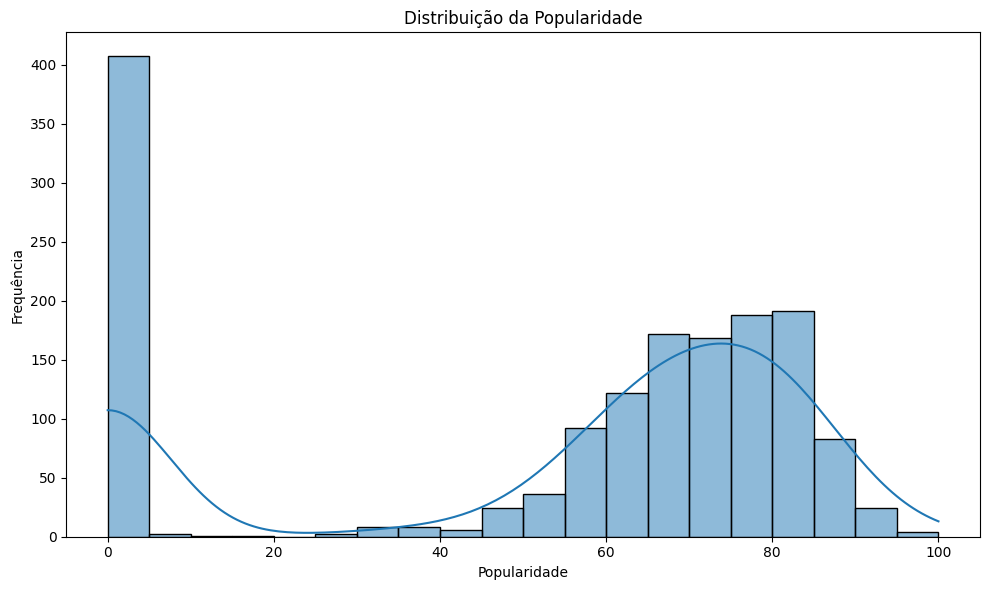

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df["popularidade"], bins=20, kde=True)
plt.title("Distribuição da Popularidade")
plt.xlabel("Popularidade")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


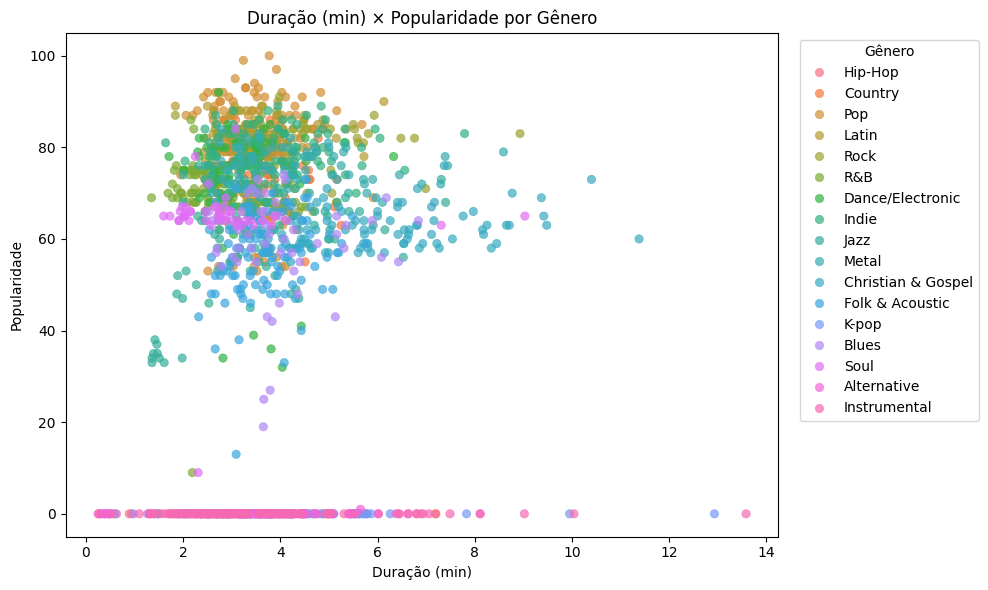

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="duracao_min", y="popularidade", hue="genero", alpha=0.7, edgecolor=None)
plt.title("Duração (min) × Popularidade por Gênero")
plt.xlabel("Duração (min)")
plt.ylabel("Popularidade")
plt.legend(title="Gênero", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


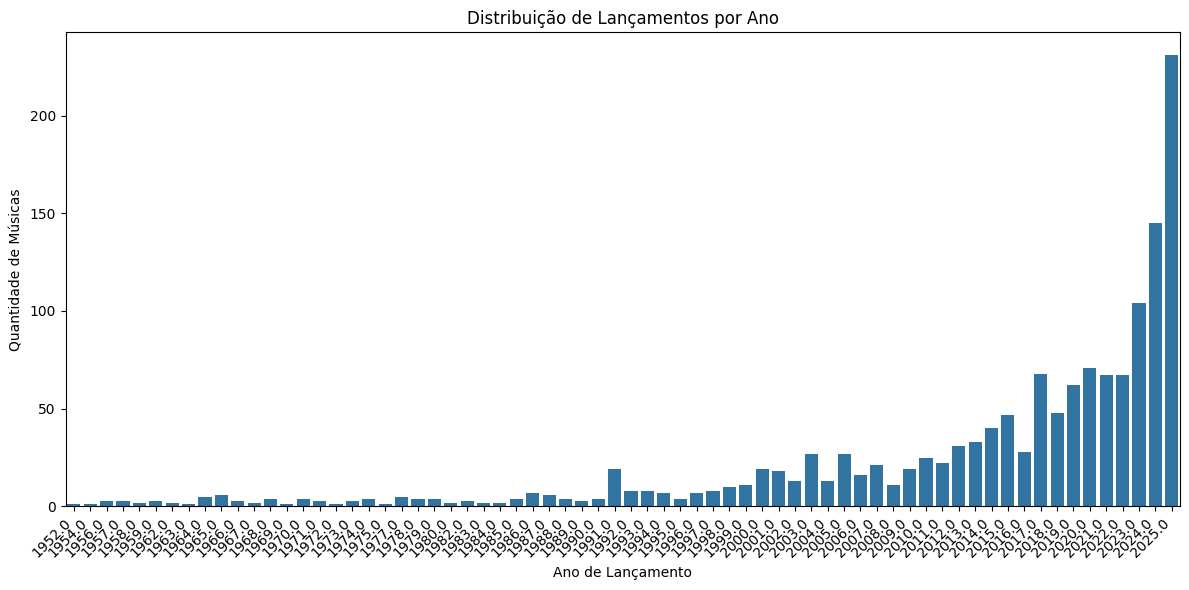

In [34]:
# Filtra anos válidos e ordena
tmp = df.dropna(subset=["ano_lancamento"]).copy()
tmp = tmp[tmp["ano_lancamento"].between(1950, 2035)]

plt.figure(figsize=(12,6))
sns.countplot(data=tmp.sort_values("ano_lancamento"), x="ano_lancamento")
plt.title("Distribuição de Lançamentos por Ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Quantidade de Músicas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


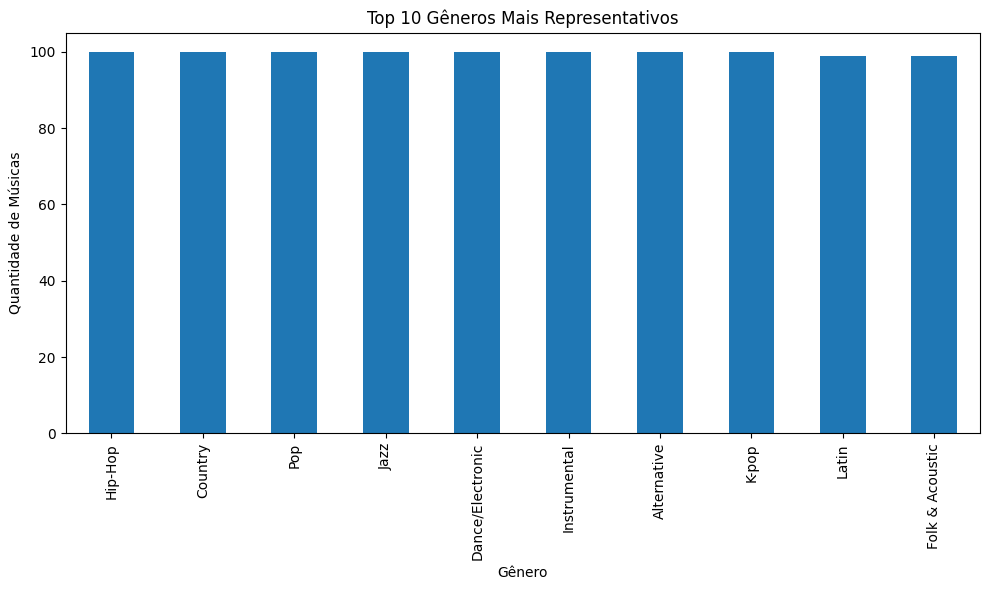

In [35]:
# Top 10 gêneros
top_genres = df["genero"].value_counts().head(10)

plt.figure(figsize=(10,6))
top_genres.plot(kind="bar")
plt.title("Top 10 Gêneros Mais Representativos")
plt.xlabel("Gênero")
plt.ylabel("Quantidade de Músicas")
plt.tight_layout()
plt.show()

# (Opcional) Top 10 artistas
# top_artistas = df["artista"].value_counts().head(10)
# plt.figure(figsize=(10,6))
# top_artistas.plot(kind="bar")
# plt.title("Top 10 Artistas Mais Representativos")
# plt.xlabel("Artista")
# plt.ylabel("Quantidade de Músicas")
# plt.tight_layout()
# plt.show()


In [37]:
## 🧭 Interpretação Técnica (resumo)

- **Popularidade**: descreva a concentração (ex.: assimetria, moda, presença de cauda).
- **Duração × Popularidade**: indique tendências (ex.: faixas mais curtas concentram maior popularidade?).
- **Lançamentos por Ano**: destaque períodos de alta produção (ex.: crescimento recente com plataformas digitais).
- **Gêneros Dominantes**: aponte estilos com maior presença na amostra.

> **Melhoria aplicada:** sob cada gráfico, inclua 1–2 frases de *insight* apontando
> tendências e possíveis correlações (para alimentar o storytelling da Semana 4).


SyntaxError: invalid character '×' (U+00D7) (ipython-input-3771152987.py, line 4)

In [38]:
import os
from matplotlib import pyplot as plt

outdir_candidates = ["/content/visuals", "./visuals"]
outdir = next((p for p in outdir_candidates if (os.path.dirname(p) == "" or os.path.exists(os.path.dirname(p)) or True)), outdir_candidates[0])
os.makedirs(outdir, exist_ok=True)

# Salva todas as figuras geradas na sessão
for i, fignum in enumerate(plt.get_fignums(), start=1):
    plt.figure(fignum)
    plt.savefig(os.path.join(outdir, f"semana3_fig_{i}.png"), dpi=300, bbox_inches="tight")

print(f"💾 Gráficos salvos em: {outdir}")


💾 Gráficos salvos em: /content/visuals
